In [126]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [127]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Logistic Regression - prepare data and train model

Churn prediction is about identifying customers who are likely to cancel their contracts soon. If the company can do that, it can offer discounts on these services in an effort to keep the users. Here we use the dataset of churn prediction for a telecom company.

- A value of 0 indicates that the customer did not churn (they stayed with the service).
- A value of 1 indicates that the customer did churn (they left the service).

In [128]:
df = pd.read_csv('Data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert 'TotalCharges' to numeric, replace non-numeric with NaN
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
# Fill NaN values with zero
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# lowering columns name and replace spaces by _
df.columns  = df.columns.str.lower().str.replace(' ', '_')


# boolean mask to select columns with object type (string)
obj_mask = df.dtypes == 'object' 
obj_columns = list(df.dtypes[obj_mask].index)

# lowering rows strings and replace spaces by _
for col in obj_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# turn 'no' into 0 and 'yes' into 1
df.churn = (df.churn == 'yes').astype(int)

In [129]:
# split data in train, test, validation
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

# save target values
y_train = df_train['churn'].values
y_val = df_val['churn'].values

# take out the target values from the dataframe
del df_train['churn']
del df_val['churn']

In [130]:
# All categorical columns except 'customerid'
categorical_mask = df_train.dtypes == 'object'
categorical = list(df_train.dtypes[categorical_mask].index)
categorical.remove('customerid') 

# Manually add 'seniorcitizen' because it's an int boolean (0 or 1)
categorical.append('seniorcitizen')
printest('categorical', categorical)

# All numerical columns except 'seniorcitizen' because it's an int boolean
numerical_mask = df_train.dtypes != 'object'
numerical = list(df_train.dtypes[numerical_mask].index)
numerical.remove('seniorcitizen')
printest('numerical', numerical)

categorical : 
 ['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'seniorcitizen'] 

numerical : 
 ['tenure', 'monthlycharges', 'totalcharges'] 



In [131]:
# transform dataframe to dict
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# One-hot encoding
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

# Model train for all relevant features
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [132]:
# validate the model
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)
printest('Prob Not churn| Prob Churn',y_pred)

Prob Not churn| Prob Churn : 
 [[0.76508893 0.23491107]
 [0.7311339  0.2688661 ]
 [0.6805482  0.3194518 ]
 ...
 [0.94274725 0.05725275]
 [0.38476961 0.61523039]
 [0.93872737 0.06127263]] 



In [133]:
# training the model for a subset of features
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)
printest('Prob Not churn| Prob Churn',y_pred)

Prob Not churn| Prob Churn : 
 [[0.76508893 0.23491107]
 [0.7311339  0.2688661 ]
 [0.6805482  0.3194518 ]
 ...
 [0.94274725 0.05725275]
 [0.38476961 0.61523039]
 [0.93872737 0.06127263]] 



# Metrics

Evaluation metrics serve as a critical tool for quantifying the performance of a model. They function by assessing the model's predictions against the actual observed values. This comparison yields a measurement that indicates the model's predictive accuracy. Therefore, evaluation metrics provide an essential insight into the model's proficiency and its ability to generalize to unseen data.

## Classification accuracy

The accuracy of a binary classification model is determined by the proportion of predictions it correctly makes relative to the total number of predictions. In mathematical terms, this can be represented as:

$$\text{Accuracy} = \frac{\text{correct}}{\text{total}} = \frac{1491}{1860} = 80\%$$

This metric provides valuable insight into the model's performance. By tallying the instances where our model's predictions align with the actual results.

In [134]:
# calculate accuracy explicitly
y_pred = model.predict_proba(X_val)[:, 1]
# probability threshold
churn = y_pred >= 0.5
correct = (y_val == churn).sum()
total = len(y_val)
accuracy = correct/total
printest('Full Model Accuracy', accuracy)

Full Model Accuracy : 
 0.8016129032258065 



In [138]:
# calculate accuracy explicitly
y_pred_small = model_small.predict_proba(X_small_val)[:, 1]
# probability threshold
churn = y_pred_small >= 0.5
correct = (y_val == churn).sum()
total = len(y_val)
accuracy = correct/total
printest('Small Model Accuracy', accuracy)

Small Model Accuracy : 
 0.7672043010752688 



In order to determine the optimal threshold, we can iteratively calculate the accuracy for a range of potential threshold values. This process allows us to assess the performance of our model at various decision boundaries, thereby enabling us to select the threshold that yields the highest accuracy.

In [ ]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    #print('%0.2f %0.3f' % (t, acc))

# Create a dictionary
data = {'threshold': thresholds, 'accuracy': accuracies}

# Create DataFrame
df_acc = pd.DataFrame(data)

# Print DataFrame
display(df_acc.set_index('threshold'))

,accuracy
threshold,
0.00,0.261290
0.05,0.501075
0.10,0.594624
0.15,0.640323
0.20,0.689785
0.25,0.729570
0.30,0.754839
0.35,0.767204
0.40,0.781720


As we see, using the threshold of 0.5 gives us the best accuracy. Typically, 0.5 is a good
threshold value to start with. To make it more visual, we can use Matplotlib to create a plot that shows how accuracy changes depending on the threshold

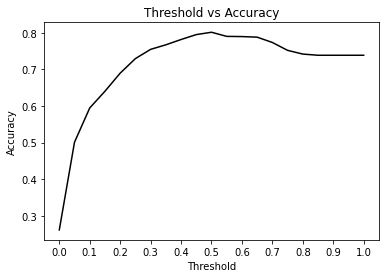

In [ ]:
plt.figure(figsize=(6, 4))

plt.plot(df_acc['threshold'].values, df_acc['accuracy'].values, color='black')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

### Dummy baseline

Establishing a baseline is an important step in evaluating the performance of our predictive models. For this purpose, we often use a dummy model — a simple construct which consistently predicts the same outcome, regardless of the input features. In our case, it consistently outputs 'False'. 

By comparing the performance of our complex models against this baseline, we gain a clear understanding of their incremental improvement in predictive accuracy. 

In [140]:
# dummy model that outputs only False
size_val = len(y_val)
baseline = np.repeat(False, size_val)


printest('Full Model Accuracy', accuracy)
printest('Small Model Accuracy', accuracy)
printest('Baseline accuracy', accuracy_score(baseline, y_val))

Full Model Accuracy : 
 0.7672043010752688 

Small Model Accuracy : 
 0.7672043010752688 

Baseline accuracy : 
 0.7387096774193549 



Observing the performance of our models, we notice that the smaller model surpasses the naive baseline by a marginal 2%, while the larger model achieves a slightly better improvement of 6%. According to accuracy metrics, our model only offers a marginal improvement over a rudimentary model that categorizes all customers as non-churning and makes no effort to retain them. 

This phenomenon often arises in scenarios where there is class imbalance, a condition wherein one class outnumbers the other. This imbalance is indeed apparent in our dataset, where 74% of customers didn't churn while only 26% did. For this we need another metric that validate the model.

## Confusion Matrix and Measures


**Confusion Matrix for multiple classes**

The accuracy is a global measure in that it does not explicitly consider the classes that contribute to the error. A more detailed understanding can be achieved by noting the agreement and disagreement for specific classes between the actual and predicted labels in the validation or test set. 

Consider a typical dataset for the validation points with multiple classes,
$$\mathbf{D} =
\left( \begin{array}{c|cccc|c}
~    &X_{0}&X_{1}&\cdots & X_{d}  & Y\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

The target values, denoted as $\mathbf{Y} = (y_1, \cdots, y_i, \cdots, y_n)$, are not binary; instead, each $y_i \in \{c_1, \cdots, c_k\}$ represents one of $k$ class labels. Here, $\mathcal{D}= \{\mathbf{D}_1,\mathbf{D}_2, \cdots,\mathbf{D}_k\}$ denotes the division of validation data according to their true class labels $y$.

The $j^{th}$ split for the target values $y_i$ on the validation set is defined as:

$$\mathbf{D}_j = \{\mathbf{x}_i | y_i = c_j\}$$

with $n_i = |\mathbf{D}_i|$ as the count of the true class $c_i$ within the validation set.

Another division is conducted based on the predicted values from the validation set, forming $\mathcal{R} = \{\mathbf{R}_1, \mathbf{R}_2, \cdots, \mathbf{R}_k\}$. This denotes that the $j^{th}$ partition for the predicted target value $\hat{y}_i$ on the validation set is:

$$\mathbf{R}_j = \{\mathbf{x}_i | \hat{y}_i = c_j\}$$

and $m_i = |\mathbf{R}_i|$ represents the quantity of the predicted class $c_j$.

The divisions $\mathcal{R}$ and $\mathcal{D}$ yield a $k \times k$ matrix $\mathbf{N}$, better known as a confusion matrix. This matrix illustrates the intersections of each partition from the sets $\mathcal{R}$ and $\mathcal{D}$:

$$\mathbf{N}(i,j) = n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j |  = |\{\mathbf{x}_a \in \mathbf{D}| \hat{y}_a = c_j ~~\text{and} ~~ y_a = c_i \}|$$

For $1\leq i$, $j \leq k$, $n_{ij}$ represents the count of instances with a predicted class of $c_i$ and an actual label of $c_j$. These matrix values account for the total instances in each intersection. The matrix is presented as:

$$\mathbf{N} =
\left( \begin{array}{c|cccc}
~  y_{i} |~~\hat{y}_i  &c_{1}&c_{2}&\cdots & c_{k} \\
\hline
{c}_{1} &n_{11}& n_{12}& \cdots&n_{1k} \\
{c}_{2} &n_{21}& n_{22}& \cdots&n_{2k} \\
\vdots&\vdots&\vdots&\ddots&\vdots&\\
c_{k}&n_{k1}&n_{k2}&\cdots&n_{kk}
\end{array} \right).$$

The diagonal elements, $n_{ii} = |\mathbf{R}_i \cap \mathbf{D}_i|$ (for $1\leq i \leq k$), denote instances where the classifier correctly identifies the true label $c_i$. The size of $\mathbf{R}_i$ (the set of instances predicted as class $c_i$) and $\mathbf{D}i$ (the set of instances that are truly class $c_i$) and their relationship with $n_{ii}$ can provide further insights:

- If the size of $\mathbf{R}_i$ is equal to the size of $\mathbf{D}_i$, and $n_{ii}$ equals to the size of these sets, then the classifier has made perfect predictions for class $c_i$.

- If the size of $\mathbf{R}_i$ is larger than the size of $\mathbf{D}_i$, it means that the classifier has predicted more instances as class $c_i$ than there actually are.

- If the size of $\mathbf{R}_i$ is smaller than the size of $\mathbf{D}_i$, it means that the classifier has predicted fewer instances as class $c_i$ than there actually are.

The off-diagonal elements, $n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j|$ where $i \neq j$, represent instances where the classifier's predictions and the true labels diverge. If $n_{ij}$ is non-zero, it signifies that there are instances where the classifier predicted class $c_i$ while the true class was $c_j$, indicating a misclassification error.

- If the size of $\mathbf{R}_i$ is larger than the size of $\mathbf{D}_j$, it suggests that the classifier has over-predicted instances as class $c_i$ when they are actually class $c_j$. 

- If the size of $\mathbf{R}_i$ is smaller than the size of $\mathbf{D}_j$, it implies that the classifier has under-predicted instances as class $c_i$ when they are actually class $c_j$. 

To measure the quality of the classifier, we can calculate rates with respect to the sizes of each subset and their intersection:

**Accuracy/Precision**

The precision for a specific class $c_i$ is defined as the proportion of accurate predictions out of all points predicted to belong to class $c_i$:

$$\text{acc}_i = \text{prec}_i= \frac{|\mathbf{R}_i \cap \mathbf{D}_i | }{|\mathbf{R}_i|}  = \frac{n_{ii}}{m_i}$$

Here, $m_i$ is the total number of predictions for class $c_i$, and $n_{ii}$ represents instances where the classifier correctly identifies the true label $c_i$. A high precision for class $c_i$ indicates a more effective classifier.

**Covarage/Recall**

Recall, also known as coverage, for class $c_i$ is determined by the ratio of correct predictions to all points actually in class $c_i$:

$$\text{coverage}_i= \text{recall}_i = \frac{|\mathbf{R}_i \cap \mathbf{D}_i | }{|\mathbf{D}_i|} =  \frac{n_{ii}}{n_i}$$

Here, $n_i$ denotes the number of instances in class $c_i$. A high recall for class $c_i$ implies a more capable classifier.

**F-Measures**

Precision and recall often present a trade-off when assessing classifier performance. The F-measure seeks to balance these values by calculating their harmonic mean for class $c_i$:

- If $\text{recall}_i = 1$, the classifier predicts all validation points as belonging to class $c_i$. However, this will usually result in a low precision $\text{prec}_i$.

- If $\text{prec}_i$ is very high because the classifier predicts only a few points as $c_i$, the recall $\text{recall}_i$ is likely to be low.

The F-measure seeks to harmonize the precision and recall values by calculating their harmonic mean for class $c_i$:

$$F_i = \frac{2}{\frac{1}{\text{prec}_i} + \frac{1}{\text{recall}_i}} = \frac{2\text{prec}_i \text{recall}_i}{\text{prec}_i + \text{recall}_i} = \frac{2n_{ii}}{n_i + m_i}$$

The higher the $F_i$ value, the more effective the classifier for the specific class.

The overall F- measure for the classifier is the mean of the class-specific values:

$$F = \frac{1}{k}\sum^r_{i=1}F_i$$

For perfect classifier, the maximum value of F measure is 1.


**Confusion Matrix for Binary classes**

After considering a general case of multiple classes, we now turn our focus to the specific instance of binary classification. In such a scenario, where $k = 2$, we designate $c_1 = c_+$ as the positive class and $c_2 = c_{~-}$ as the negative class. The target values are represented as $\mathbf{Y} = (y_{~+}, y_{~-})$. Consequently, the sets of true values are denoted as $\mathcal{D} = {\mathbf{D}_{~-}, \mathbf{D}_{~+}}$, and the predicted values are indicated as $\mathcal{R} = {\mathbf{R}_{~-}, \mathbf{R}_{~+}}$. The divisions $\mathcal{R}$ and $\mathcal{D}$ form a $2 \times 2$ matrix, as presented below:

$$\mathbf{N} =
\left( \begin{array}{c|cc}
~  y_{i} |~~\hat{y}_i  &c_{~+}& c_{~-} \\
\hline
{c}_{~+} &n_{11}& n_{12}&  \\
{c}_{~-} &n_{21}& n_{22}&  \\
\end{array} \right).$$

Each entry of the matrix corresponds to the size of the intersection of the subsets $n_{ij} = |\mathbf{R}_i \cap \mathbf{D}_j |$ for $i,j = \{+,-\}$. In the context of binary classification, each entry of the matrix is given a specific name:

- **True Positives (TP)**: the number of points that the classifier correctly predicts as positive:
  
  $$\text{TP} = n_{11} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~+}\}|$$


- **False Positives (FP)**:The number of points the classifier predicts to be positive, wich in fact belong to the negative class:

  $$\text{FP} = n_{12} = |\mathbf{R}_{~+} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~+}~~\text{and}~~ y_i = c_{~-}\}|$$
 
- **False Negatives (FN)**: The number of points the classifier predicts to be in the negative class, wich in fact belongs to the positive class:

  $$\text{FN} = n_{21} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~+} | = |\{\mathbf{x}_i|\hat{y}_i = c_{~-}~~\text{and}~~ y_i = c_{~+}\}|$$

- **True Negatives (TN)**: The number of points that the classifier correctly predicts as negative:

  $$\text{TN} = n_{22} = |\mathbf{R}_{~-} \cap \mathbf{D}_{~-} | = |\{\mathbf{x}_i|\hat{y}_i = y_i = c_{~-}\}|$$


**Global Measures**

Global measures of the classifier performance

- **Error rate**: The proportion of incorrect predictions:

$$\text{Error Rate} = \frac{\text{FP} + \text{FN}}{n}$$

- **Accuracy**: The proportion of correct predictions:

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{n}$$

where $n$ is the total points in the validation dataset.

**Class Specific Measures**

- **Precision**: The ratio of correct predictions to all points predicted to belong to the positive or negative class

 $$\text{prec}_i = \frac{n_{ii}}{m_i} = \left\{ \begin{array}{ll} 
\frac{n_{11}}{m_{~+}} = \frac{\text{TP}}{\text{TP}+\text{FP}} \\
\\
\\
\frac{n_{22}}{m_{~-}} = \frac{\text{TN}}{\text{TN}+\text{FN}}
\end{array}\right.$$

 where $m_i = |\mathbf{R}_i|$ is the number of points predicted having class $c_i$

- **Recall**: The proportion of correct predictions out of all points in the positive or negative class.
  
  - **True Positive Rate (Sensitivity)**: 

  $$\text{recall}_{~+} = \text{sensitivity}= \frac{n_{11}}{n_{~+}} =\frac{\text{TP}}{\text{TP}+\text{FN}}  $$

  where $n_{~+} = |\mathbf{D}_{~+}|$  is the size of the positive class.

  - **True Negative Rate (Specificity)**:

  $$\text{recall}_{~-} = \text{specificity} = \frac{n_{22}}{n_{~-}} = \frac{\text{TN}}{n_{~-}} = \frac{\text{TN}}{\text{FP}+\text{TN}} $$

   where $n_{~-} = |\mathbf{D}_{~-}|$ is the size of the negative class.

- **$1 -$ Recall** : The ratio of incorrect predictions to all points in the positive or negative class.

  - **False Negative Rate (FNR)**:
    
    $$1- \text{sensitivity} = \frac{n_{21}}{n_{~+}} =  \frac{\text{FN}}{\text{TP}+\text{FN}}$$
    
  - **False Positive Rate (FPR)**:

    $$1- \text{specificity} = \frac{ n_{12} } {n_{~-}} =  \frac{ \text{FP} }{ \text{FP}+\text{TN} }$$